<a href="https://colab.research.google.com/github/Next-Sunshine/TTF0318/blob/master/TTFTest_Github_a2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@test{"skip":true}
!pip install --quiet --upgrade tensorflow_federated

     |████████████████████████████████| 430kB 2.5MB/s 
     |████████████████████████████████| 20.0MB 89.0MB/s 
     |████████████████████████████████| 421.8MB 38kB/s 
     |████████████████████████████████| 450kB 45.2MB/s 
     |████████████████████████████████| 3.9MB 45.0MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [0]:
import  collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

tf.compat.v1.enable_v2_behavior()
#TODO(b/148678573,b/148685415):must use the ReferenceExecutor because
#it supports unbounded references and tff.sequence_* intrinsics
tff.framework.set_default_executor(tff.framework.ReferenceExecutor())

In [0]:
@tff.federated_computation
def hello_world():
  return 'Hello, World!'
hello_world()

'Hello, World!'

In [0]:
#加载MNIST数据集
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
#x.dtype应该是数据类型，uint8是8位无符号整型，x.shape是在打印x的维度
[(x.dtype, x.shape) for x in mnist_train]

[(dtype('uint8'), (60000, 28, 28)), (dtype('uint8'), (60000,))]

In [0]:
#batch翻译为批，CNN是分批处理，batch_size就是每批处理的大小
#NUM_EXAMPLES_PER_USER是每个用户的样本数，每个用户有1000个样本，每次处理100个
NUM_EXAMPLES_PER_USER = 1000
BATCH_SIZE = 100

def get_data_for_digit(source,digit):
  output_sequence = []
  #如果没有猜错，i代表的是客户端的序号，d代表的是数字
  all_samples = [i for i, d in enumerate(source[1]) if d == digit]
  for i in range(0, min(len(all_samples), NUM_EXAMPLES_PER_USER), BATCH_SIZE):
    batch_samples = all_samples[i:i+ BATCH_SIZE]
    output_sequence.append({
        'x':
        #flatten（）函数用于降维，返回一个一维数组，默认是按行的方向降维
        np.array([source[0][i].flatten() / 255.0 for i in batch_samples],
                 dtype = np.float32),
        'y':
        np.array([source[1][i] for i in batch_samples], dtype= np.int32)
    })
  return output_sequence
federated_train_data = [get_data_for_digit(mnist_train, d) for d in range(10)]
federated_test_data = [get_data_for_digit(mnist_test, d) for d in range(10)]

In [0]:
#查看第5个客户端提供的最后一批数据中的Y张量，输出结果有100个5，说明每个客户端100张图片
#-1代表最后一列,好处是不知道一共有多少列也可以选定，一列是一批？
federated_train_data[5][-1]['y']

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int32)

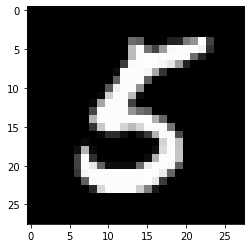

In [0]:
#查看与该批次相对应的最后一个元素相对应的图像
from matplotlib import pyplot as plt

plt.imshow(federated_train_data[5][-1]['x'][-1].reshape(28,28), cmap = 'gray')
plt.grid(False)
plt.show()

In [0]:
#定义批的tff类型
#OrderedDict根据传入的顺序安排字典，而不是按照字母顺序安排字典
BATCH_SPEC = collections.OrderedDict(
    #维度设置为None表示大小未知,784列，数据类型为32位浮点
    x = tf.TensorSpec(shape=[None, 784], dtype=tf.float32),
    y = tf.TensorSpec(shape=[None], dtype=tf.int32)
)
#to_type将指定类型转换成tff类型
BATCH_TYPE = tff.to_type(BATCH_SPEC)
#BATCH_TYPE是一个二维的数组x和一个一维的数组y
str(BATCH_TYPE)

'<x=float32[?,784],y=int32[?]>'

In [0]:
#定义模型的tff类型
MODEL_SPEC = collections.OrderedDict(
    weights = tf.TensorSpec(shape=[784, 10], dtype=tf.float32),
    bias = tf.TensorSpec(shape=[10], dtype=tf.float32)
)
MODEL_TYPE = tff.to_type(MODEL_SPEC)

print(MODEL_TYPE)

<weights=float32[784,10],bias=float32[10]>


In [0]:
# NOTE: 'forward_pass' is defined separately from 'batch_loss'
#so that it can be later called from within another tf.function.
#Necessary because a @tf.function decorated method cannot
# invoke a @tff.tf_computation.
#@tf.function将一个函数编译成一个可调用的TensorFlow图？示例代码说的是可以使函数中的类型
#在对应位按照定义的函数操作且最后数据类型不变，数组对应位操作完了仍然是数组
#forward_pass是使用前向传播计算损失？
@tf.function
def forward_pass(model, batch):
  #tf.nn.softmax把一个N*1的向量归一化为（0,1）之间的特征值使得向量中数值较大的量特征更明显
  #softmax输出向量的意思就是样本属于每个类的概率
  predicted_y = tf.nn.softmax(
      #batch为什么会有‘x'
      #tf.matmul是线代矩阵相乘，应满足矩阵相乘条件且元素类型相同，返回一个新矩阵，tf.multiply则是矩阵的对应元素相乘
      tf.matmul(batch['x'], model['weights']) + model['bias']
  )
  #reduce_mean(tensor,axis,Keepdim,name)降维计算数组的平均值,axis控制轴，没有则计算所有数的平均值返回一个数，
  #0按列计算平均值，返回列个数，1按行计算平均值返回行个数
  #其实应该是0代表第一个[[1,1,1],[1,1,1]]维度,去掉第一个[]即[1+1,1+1,1+1],1则第二个维度[1+1+1,1+1+1]去掉第第一二个[]
  return -tf.reduce_mean(
      #reduce_sum(tensor,axis,Keepdim,name)降维计算张量的总和
      tf.reduce_sum(
      #构造一个独热码，batch['y']指示的地方是1，其他地方是0
      tf.one_hot(batch['y'], 10) * tf.math.log(predicted_y), axis=[1])
  )
#定义tff类型的函数，输入值是MODEL_TYPE类型和BATCH_TYPE类型
#用@tff.computation修饰的函数调用@tf.function修饰的函数，是因为@tff修饰的函数里面不能有tf的数据类型？
#batch_loss函数计算损失
@tff.tf_computation(MODEL_TYPE, BATCH_TYPE)
def batch_loss(model, batch):
  return forward_pass(model, batch)

In [0]:
#signature告诉我们，batch_loss接受一个列表作为输入，列表里面还有两个小列表，分别放着权重偏斜、xy然后返回一个32位的浮点损失
str(batch_loss.type_signature)

'(<<weights=float32[784,10],bias=float32[10]>,<x=float32[?,784],y=int32[?]>> -> float32)'

In [0]:
#初始模型，使用特定大小的以0填充初始化
initial_model = collections.OrderedDict(
    #np.zeros()返回一个给定形状的用0填充的数组，这里为什么要用0来填充权重和偏斜
    weights = np.zeros([784, 10], dtype=np.float32),
    bias = np.zeros([10], dtype=np.float32)
)
#批样本使用训练数据的第五行最后一列，为什么？
sample_batch = federated_train_data[5][-1]
batch_loss(initial_model, sample_batch)

2.3025854

In [0]:
#定义一个计算，使用损失函数执行单步梯度下降，batch_train函数更新权重和偏移，接收一个BATCH_TYPE进行训练，后面的local_train接收一群BATCH_TYPE
@tff.tf_computation(MODEL_TYPE, BATCH_TYPE, tf.float32)
def batch_train(initial_model, batch, learning_rate):
  #Define a group of model variables and set them to 'initial_model'
  #Must be defined outside the @tf.function.
  #什么意思？？定义一组模型变量（name，value）进initial_model？那里面的name和value值从哪儿来？？
  model_vars = collections.OrderedDict([
      #tf.Variable()构造一个变量添加进图中，通过构造以后该变量的形状和类型不能改但是可以通过assign函数改
      (name, tf.Variable(name=name, initial_value=value))
      for name, value in initial_model.items()                                  
  ])
  #tf.keras.optimizers.SGD（）执行随机梯度下降和动量优化
  #实例化一个优化函数并基于一定的学习率进行训练
  optimizer = tf.keras.optimizers.SGD(learning_rate)

  #此处定义函数_train_on_batch()但是并没有调用，所以在后面return的时候才是调用
  @tf.function
  def _train_on_batch(model_vars, batch):
    # Perform one step of gradient descent using loss from batch_loss（从batch_loss中使用loss执行单步梯度下降）
    #使用tf.GradientTape计算梯度
    with tf.GradientTape() as tape:
      #forward_pass（）使用前向传播的方式计算损失？？？
      loss = forward_pass(model_vars, batch)
    #.gradient执行求导操作
    #grads相当于dloss/dmodel_vars,即loss对model_vars求导
    grads = tape.gradient(loss, model_vars)
    #apply_gradients(grads_and_vars, global_step=None, name=None)将计算出的梯度应用到变量上（计算变量为某一定值时的梯度）,对global_step作自增操作
    optimizer.apply_gradients(
        #zip([iterator1,iterator2,]) 将可迭代对象中对应的元素打包成一个元组，返回有这些元组组成的对象，用list把这个对象转化成列表
        #例如a=[1,2,3]b=[4,5,6],zip(a,b)=[(1,4),(2,5),(3,6)]
        #flatten用于降维，返回一个一维数组，默认按行降维
        zip(tf.nest.flatten(grads), tf.nest.flatten(model_vars)) )
    #这里返回model_vars，这个变量哪里被改变了？
    return model_vars
    
  return _train_on_batch(model_vars, batch)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
#输入<权重,偏移>model、<x,y>batch，输出权重和偏移也就是新模型，batch_train是在更新权重和偏移
str(batch_train.type_signature)

'(<<weights=float32[784,10],bias=float32[10]>,<x=float32[?,784],y=int32[?]>,float32> -> <weights=float32[784,10],bias=float32[10]>)'

In [0]:
#最开始使用初始化模型，sample_batch的初始值为federated_train_data[5][-1]
#将batch_train多次应用于初始模型，看损失是否减少
model = initial_model
loses = []
for _ in range(5):
  #batch_train更新权重和偏移，但是返回值model_vars没有看到在哪里被改变
  model = batch_train(model, sample_batch, 0.1)
  loses.append(batch_loss(model, sample_batch))

In [0]:
loses

[0.19690023, 0.13176315, 0.10113225, 0.08273812, 0.07030139]

In [0]:
#构造一个序列化，则LOCAL_DATA_TYPE代表了一群BATCH_TYPE，来自一个用户的所有批的整个序列计算
LOCAL_DATA_TYPE = tff.SequenceType(BATCH_TYPE)
@tff.federated_computation(MODEL_TYPE, tf.float32, LOCAL_DATA_TYPE)
def local_train(initial_model, learning_rate, all_batches):
  #Mapping function to apply to each batch.
  #定义batch_fn函数使用一个batch进行训练，更新模型参数
  @tff.federated_computation(MODEL_TYPE, BATCH_TYPE)
  def batch_fn(model, batch):
    return batch_train(model, batch, learning_rate)
  #tff.sequence.reduce(value,zero,fn)在给定zero和操作fn的情况下对value进行操作以减少序列值
  #tff.sequence.reduce和tf.data.Dataset.reduce作用差不多，只是前面一个用于联邦计算，联邦计算里面不能包含TensorFlow代码
  #此处不停将batch_fn应用于all_batches中的每一个元素和initial然后将得到的结果赋值给initial_model？
  return tff.sequence_reduce(all_batches, initial_model, batch_fn)

In [0]:
#local_train返回的是<权重,偏移>，则返回值是模型
str(local_train.type_signature)

'(<<weights=float32[784,10],bias=float32[10]>,float32,<x=float32[?,784],y=int32[?]>*> -> <weights=float32[784,10],bias=float32[10]>)'

In [0]:
#federated_test_data[5]代表的是一个用户的所有batch，local_train计算了一个用户的所有batch
locally_trained_model = local_train(initial_model, 0.1, federated_test_data[5])

In [0]:
#LOCAL_DATA_TYPE代表一群batch，即每个用户的所有batch序列
@tff.federated_computation(MODEL_TYPE, LOCAL_DATA_TYPE)
def local_eval(model, all_batches):
  #TODO(b/120157713):Replace with tff.sequence_average() once implemented.
  #tff.sequence.sum则计算loss的总和，这里是计算某个模型在特定数据集上面的表现
  return tff.sequence_sum(
      tff.sequence_map(
          #lambda匿名函数:之前代表是匿名函数的参数
          #将匿名函数应用到all_batches里面的每一个batch，然后会得到loss
          tff.federated_computation(lambda b: batch_loss(model, b),BATCH_TYPE),
          all_batches
      )
  )

In [0]:
#signature表明，local_eval函数接收一个模型，一群batch作为输入最后返回一个32位浮点（损失）
str(local_eval.type_signature)

'(<<weights=float32[784,10],bias=float32[10]>,<x=float32[?,784],y=int32[?]>*> -> float32)'

In [0]:
#初始模型
print('initial_model loss=', local_eval(initial_model, federated_train_data[5]))
#进行了第五个用户所有batch训练之后的模型
print('locally_trained_model loss=', local_eval(locally_trained_model, federated_train_data[5]))

initial_model loss= 23.025854
locally_trained_model loss= 0.57459134


In [0]:
#查看该模型在其他数据集上面的表现，表明为用户5训练的locally_trained_model只会识别5，泛化能力差
#问题：从全球的角度看，本地模型时如何影响模型质量
print('initial_model loss=', local_eval(initial_model, federated_train_data[0]))
print('locally_trained_model loss=', local_eval(locally_trained_model, federated_train_data[0]))

initial_model loss= 23.025854
locally_trained_model loss= 72.66378


In [0]:
#定义服务器模型类型，MODEL_TYPE@SERVER
SERVER_MODEL_TYPE = tff.FederatedType(MODEL_TYPE, tff.SERVER)
#定义客户端数据类型，LOCAL_DATA_TYPE(一群batch)@CLIENTS
CLIENT_DATA_TYPE = tff.FederatedType(LOCAL_DATA_TYPE, tff.CLIENTS)

In [0]:
#又定义federated_eval此时接收服务器的模型和客户端的batch
@tff.federated_computation(SERVER_MODEL_TYPE,CLIENT_DATA_TYPE)
def federated_eval(model, data):
  #federated_mean计算所有客户端的平均损失
  return tff.federated_mean(
      #tff.federated_broadcast将模型分发给客户机，让每个客户机对本地的数据调用本地计算，相当于{model_type@CLIENTS}
      #有一个问题是怎么知道哪个客户机对应的data
      #{model_type@CLIENTS，data_type@CLIENTS}和{<model，data>@CLIENTS}等价，前面那个会发生隐式转换，相当于调用了tff.federated_zip
      #local_eval(model，all_batches)，federated_map将local_eval应用到每个客户端计算每个客户端的损失
      tff.federated_map(local_eval, [tff.federated_broadcast(model),data])
  )

In [0]:
print('initial_model loss=', federated_eval(initial_model, federated_train_data))
print('locally_trained_model, loss=', federated_eval(locally_trained_model, federated_train_data))
#通过结果可以看出，损失增加，所以要改进每个用户的模型，需要对每个人的数据进行培训

initial_model loss= 23.025852
locally_trained_model, loss= 52.793297


In [0]:
#实现联合训练最简单的方法是本地训练然后对模型进行平均
#构造一个SERVER_FLOAT_TYPE服务器数据类型，是一个放置在SERVER上的32位浮点
SERVER_FLOAT_TYPE = tff.FederatedType(tf.float32, tff.SERVER)
#该函数接收三个参数，放置在SERVER上的模型和浮点数，放置在CLIENT上面的一群batch（分别是模型，浮点数，训练数据）
@tff.federated_computation(SERVER_MODEL_TYPE, SERVER_FLOAT_TYPE, CLIENT_DATA_TYPE)
def federated_train(model, learning_rate, data):
  #前面已经说过，tff.federated_mean是计算model的联邦平均，最后求权重和偏移的平均？
  return tff.federated_mean(
      #此处相当于tff.federated_map(local_train，[{model,learning_rate,data}@CLIENTS])
      #local_train是在给定的模型中以给定的学习率训练batch，然后返回一个model
      tff.federated_map(local_train, [tff.federated_broadcast(model),tff.federated_broadcast(learning_rate),data])
  )

In [0]:
#开始真正的fed训练：进行几轮训练并比较前后的平均损失
model = initial_model
learning_rate = 0.1
for round_num in range(5):
  #每一轮将大家的模型分别更新，取平均之后又拿回来，federated_train_data是MNIST数据集里面的训练数据
  model = federated_train(model, learning_rate, federated_train_data)
  #更新学习率
  learning_rate = learning_rate * 0.9
  #计算loss
  loss = federated_eval(model, federated_train_data)
  print('round{}, loss={}'.format(round_num, loss))
  #下一轮统一的模型又还给各位CLIENTS去更新

round0, loss=21.60552406311035
round1, loss=20.365678787231445
round2, loss=19.27480125427246
round3, loss=18.31110954284668
round4, loss=17.45725440979004


In [0]:
#在训练出来的模型上运行测试数据
print('initial_model test loss=', federated_eval(initial_model, federated_test_data))
print('trained_model test loss=', federated_eval(model, federated_test_data))

initial_model test loss= 22.795593
trained_model test loss= 17.278767
